<a href="https://colab.research.google.com/github/pollyjuice74/5G-Decoder/blob/main/LTD_model_reg_LDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!git clone https://github.com/pollyjuice74/5G-Decoder
!pip install sionna

Cloning into '5G-Decoder'...
remote: Enumerating objects: 1482, done.
remote: Counting objects: 100% (1482/1482), done.
remote: Compressing objects: 100% (542/542), done.
remote: Total 1482 (delta 938), reused 1462 (delta 926), pack-reused 0 (from 0)
Receiving objects: 100% (1482/1482), 1.84 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (938/938), done.


In [53]:

import tensorflow as tf
import random
import numpy as np
import time
from scipy.sparse import issparse, csr_matrix

from sionna.fec.utils import generate_reg_ldpc, load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

import os
# os.chdir('../..')
if os.path.exists('5G-Decoder'):
  os.rename('5G-Decoder', '5G_Decoder')
os.chdir('5G_Decoder/adv_nn')

from dataset import *
from attention import *
from channel import *
from args import *
from model_functs import *
from models import *

Loading LDPC code
Setting n to:  6
Number of edges (VN perspective):  6
Number of edges (CN perspective):  6
Generated regular (1,2) LDPC code of length n=6
Code rate is r=0.500.
(3, 6) (2, 6)


<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0],
       [0, 0]], dtype=int32)>

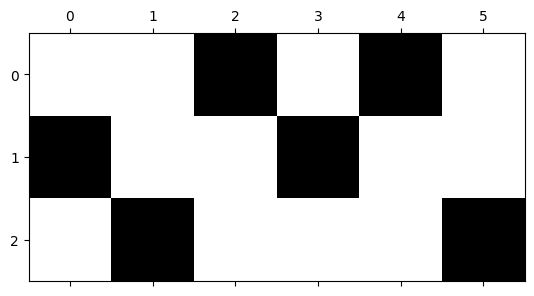

In [54]:
print("Loading LDPC code")
pcm, k, n, coderate = generate_reg_ldpc(v=1,
                                        c=2,
                                        n=5,
                                        allow_flex_len=True,
                                        verbose=True)

# pcm = tf.cast(pcm, dtype=tf.int32)
encoder = LinearEncoder(pcm, is_pcm=True, dtype=tf.int32)

batch_size = 2  # For multiple codewords
b = tf.random.uniform((batch_size, k), minval=0, maxval=2, dtype=tf.int32)
c = encoder(b)
print(pcm.shape, c.shape)
pcm @ tf.transpose(c) % 2

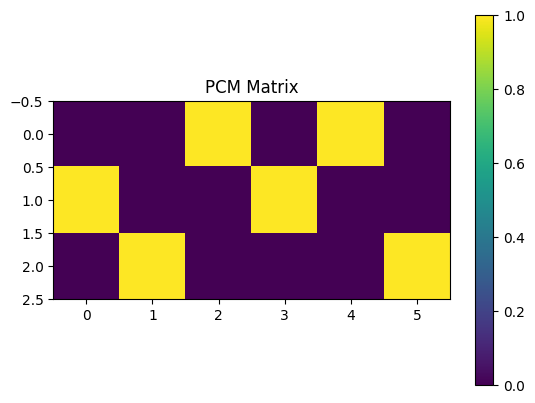

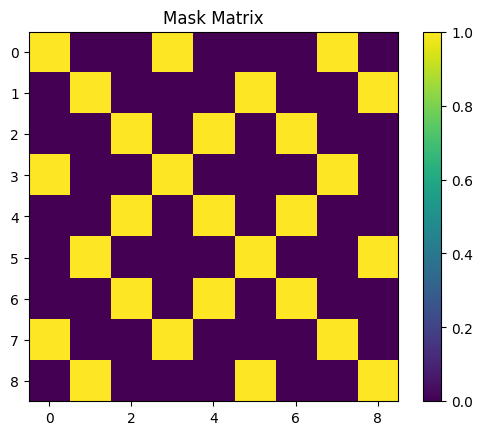

In [66]:
# for e2e model
from sionna.utils import BinarySource, ebnodb2no
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
# from sionna.fec.ldpc import LDPC5GDecoder, LDPC5GEncoder
from tensorflow.keras.layers import Layer, Dense, Dropout
import matplotlib.pyplot as plt


class Args():
    def __init__(self, model_type, code_type='LDPC', n_look_up=121, k_look_up=80, n=400, k=200,
                       n_rings=2, ls_active=True, split_diff=True, sigma=0.1,
                       t_layers=2, d_model=32, heads=8, lr=5e-4,
                       batch_size=160, batch_size_eval = 150,
                       eval_train_iter=50, save_weights_iter=100,
                       ebno_db_eval=2.5,
                       ebno_db_min=0., ebno_db_max=4., ebno_db_stepsize=0.25,
                       traindata_len=500, testdata_len=250,
                       mc_batch_size=200, mc_iters=500, epochs=10000):
        assert model_type in ['gen', 'dis'], "Type must be: 'gen', Generator or 'dis', Discriminator."
        assert code_type in ['POLAR', 'BCH', 'CCSDS', 'LDPC', 'MACKAY', 'LDPC5G', 'POLAR5G'], "Invalid linear code type."

        # model data
        self.model_type = model_type

        self.split_diff = split_diff
        self.n_rings = n_rings # ring connectivity of mask
        self.sigma = sigma
        self.t_layers = t_layers
        self.ls_active = ls_active

        self.d_model = d_model
        self.heads = heads

        # training data
        self.lr = lr
        self.batch_size = batch_size
        self.traindata_len = traindata_len
        self.testdata_len = testdata_len
        self.epochs = epochs

        self.ebno_db_min = ebno_db_min
        self.ebno_db_max = ebno_db_max
        self.ebno_db_stepsize = ebno_db_stepsize

        self.ebno_db_eval = ebno_db_eval
        self.eval_train_iter = eval_train_iter
        self.save_weights_iter = save_weights_iter
        self.batch_size_eval = batch_size_eval

        # simulation
        self.mc_batch_size = mc_batch_size
        self.mc_iters = mc_iters

        # code data
        self.code_type = code_type
        self.code = self.get_code(n_look_up, k_look_up) # n,k look up values in Get_Generator_and_Parity

        # if self.code_type not in ['LDPC5G', 'POLAR5G']:
        #     self.n, self.m, self.k = self.code.n, self.code.m, self.code.k
        # else:
        #     self.n, self.m, self.k = n, n-k, k

        # self.n_steps = self.m + 5  # Number of diffusion steps

    def get_code(self, n_look_up, k_look_up):
        code = type('Code', (), {})() # class Code, no base class, no attributes/methods, () instantiate object
        # code.n_look_up, code.k_look_up = n_look_up, k_look_up
        # code.code_type = self.code_type

        # if self.code_type not in ['LDPC5G', 'POLAR5G']:
        #     G, H = Get_Generator_and_Parity(code)
        #     code.G, code.H = tf.convert_to_tensor(G), csr_matrix( tf.convert_to_tensor(H) )

        #     code.m, code.n = code.H.shape
        #     code.k = code.n - code.m

        return code

    # def attention(self, x, mask): # O(n^2)
    #     shape = tf.shape(x)
    #     b = shape[0]
    #     n = shape[1]
    #     x = x[:, :, tf.newaxis] # (b,n,1)

    #     query, key, val = self.to_q(x), self.to_k(x), self.to_v(x) # (b, n, d)
    #     query, key, val = [ tf.reshape(x, (b, n, self.heads, self.dim_head)) for x in [query, key, val] ]
    #     query, key, val = [ tf.cast( tf.transpose(x, [0, 2, 1, 3]), tf.float32 )
    #                                                                         for x in [query, key, val] ]

    #     scores = tf.einsum('bhqd,bhkd->bhqk', query, key) / (tf.sqrt( tf.cast(self.dim_head, tf.float32) ))
    #     scores += (mask * -1e9) if mask is not None else 0. # apply mask non-edge connections
    #     attn = tf.nn.softmax(scores, axis=-1) #-1
    #     attn = self.dropout(attn)
    #     out = tf.einsum('bhqk,bhkd->bhqd', attn, val)

    #     out = tf.transpose(out, [0, 2, 1, 3])
    #     out = tf.reshape(out, (b, n, -1))
    #     return self.to_out(out)


# class Decoder( TransformerDiffusion ):
#     def __init__(self, args):
#         super().__init__(args)
#         self.transformer =

#     # 'test' function
#     def call(self, r_t):
#         i = tf.constant(0)  # Initialize loop counter

#         def condition(r_t, i):
#             # Loop while i < self.m and syndrome sum is not zero
#             return tf.logical_and(i < 5, tf.reduce_sum(self.get_syndrome(r_t)) != 0) # CHANGE 5 TO SELF.M

#         def body(r_t, i):
#             # Perform reverse or split diffusion
#             r_t = tf.cond(
#                 tf.logical_not(self.split_diff),
#                 lambda: self.split_rdiff_call(r_t),
#                 lambda: self.rev_diff_call(r_t),
#             )
#             return r_t, tf.add(i, 1)

#         # Run tf.while_loop with the loop variables
#         llr_hat, _ = tf.while_loop(
#             condition,
#             body,
#             loop_vars=[r_t, i],
#             maximum_iterations=self.m,
#             shape_invariants=[tf.TensorShape([self.batch_size, self.n]), i.get_shape()]
#         )

#         # llr_hat, _ = self.tran_call(r_t)
#         tf.print("llr_hat", llr_hat)

#         return llr_hat

#     # Refines recieved codeword r at time t
#     def rev_diff_call(self, r_t):
#         tf.print("Rev def call with line-search...")

#         # Transformer error prediction
#         z_hat_crude, t = self.tran_call(r_t) # (b,n)
#         r_t1 = r_t - z_hat_crude*self.get_sigma(t)[:, tf.newaxis] # (b,n)
#         # tf.print(r_t1)

#         # # Refined estimate of the codeword for the ls diffusion step
#         # r_t1, z_hat = self.line_search(r_t, sigma, err_hat) if self.ls_active else 1.
#         # tf.print("After linesearch: ", r_t1)

#         print("r_t1", r_t1.shape, r_t1.dtype)
#         return r_t1 # r at t-1, both (b,n)

#     def split_rdiff_call(self, r_t):
#         tf.print("Rev diff call with split diffusion...")
#         # First half-step condition subproblem
#         z_hat_crude, t = self.tran_call(r_t)
#         # tf.print("fc input: ", (z_hat_crude * self.get_sigma(t)[:, tf.newaxis]))
#         r_t_half = r_t - 0.5 * self.fc( z_hat_crude * self.get_sigma(t)[:, tf.newaxis] )
#         # tf.print("r_t_half", r_t_half)

#         # Full-step diffusion subproblem
#         r_t1 = r_t_half + tf.random.normal(r_t_half.shape) * tf.sqrt(self.get_sigma(t)[:, tf.newaxis])

#         # Second half-step condition subproblem
#         z_hat_crude_half, t = self.tran_call(r_t1)  # Reuse the second `tran_call`
#         r_t1 = r_t1 - 0.5 * self.fc(z_hat_crude_half * self.get_sigma(t)[:, tf.newaxis])
#         print("r_t1", r_t1.shape, r_t1.dtype)
#         return r_t1  # r at t-1, both (b,n)

from tensorflow.keras.layers import MultiHeadAttention, Dense, LayerNormalization, Dropout

class LinearMHAttention( MultiHeadAttention ):
    def __init__(self, num_heads, key_dim, mask_shape, dropout, **kwargs):
        super().__init__(num_heads, key_dim, mask_shape, dropout, **kwargs)
        # self.num_heads = num_heads
        # self.key_dim = key_dim
        # self._dropout = dropout

        self.k_proj = self.get_k_proj(mask_shape) # mask_shape: (1, n+m, n+m)
        self.proj_k = None
        self.proj_v = None

    def build(self, input_shape, **kwargs):
        super().build(**kwargs)
        # Creates shape (n,k_proj) proj matrices for key and
        n_value = input_shape[1]
        self.proj_k = self.add_weight("proj_k", shape=[n_value, self.k_proj], initializer=GlorotUniform())
        self.proj_v = self.add_weight("proj_v", shape=[n_value, self.k_proj], initializer=GlorotUniform())

    def call(
        self,
        query,
        value,
        key=None,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        return_attention_scores=False,
        training=None,
        use_causal_mask=False,
    ):
        if key is None:
            key = value

        attention_mask = self._compute_attention_mask(
            query,
            value,
            query_mask=query_mask,
            value_mask=value_mask,
            key_mask=key_mask,
            attention_mask=attention_mask,
            use_causal_mask=use_causal_mask,
        )

        #   N = `num_attention_heads`
        #   H = `size_per_head`
        query = self._query_dense(query) # `query` = [B, T, N ,H]
        key = self._key_dense(key) # `key` = [B, S, N, H]
        value = self._value_dense(value) # `value` = [B, S, N, H]

        attention_output, attention_scores = self._compute_lin_attention(
            query, key, value, attention_mask, training
        )
        attention_output = self._output_dense(attention_output)

        if return_attention_scores:
            return attention_output, attention_scores
        return attention_output

    def _compute_lin_attention(self, x, mask): # O(n)
        shape = tf.shape(x) # (b, n, d)
        b = tf.cast(shape[0], tf.int32)
        n = tf.cast(shape[1], tf.int32)

        # # Reshape splitting for heads
        # query = tf.reshape(query, (b, n, self.heads, self.dim_head))
        # key = tf.reshape(key, (b, self.k_proj, self.heads, self.dim_head))
        # val = tf.reshape(val, (b, self.k_proj, self.heads, self.dim_head))
        # query, key, val = [ tf.transpose(x, [0, 2, 1, 3]) for x in [query, key, val] ]

        # Low-rank mask (n,k_proj)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.resize(mask, [n, self.k_proj], method='nearest')
        mask = tf.reshape(mask, (1, 1, n, self.k_proj))

        # # Main attn logic: sftmx( q@k / d**0.5 ) @ v
        # scores = tf.einsum('bhnd,bhkd->bhnk', query, key) / (tf.sqrt( tf.cast(self.dim_head, dtype=tf.float32) ))
        # scores += (mask * -1e9) if mask is not None else 0.
        # attn = tf.nn.softmax(scores, axis=-1) # (b,h,n,k_proj)
        # attn = self.dropout(attn)
        # out = tf.einsum('bhnk,bhkd->bhnd', attn, val)

        key = tf.einsum('bnd,nk->bkd', self._key_dense(x), self.proj_k)
        value = tf.einsum('bnd,nk->bkd', self._value_dense(x), self.proj_v)

        # Custom low-rank mask preprocessing
        processed_mask = self.preprocess_mask(mask, tf.shape(x)[1], self.k_proj)

        # Compute attention
        return self._compute_attention(query=self._query_dense(x),
                                       key=key,
                                       value=value,
                                       attention_mask=processed_mask)

    def get_k_proj(self, mask_shape):
        mask_length = mask_shape[1] # (b, n+m, n+m)
        # gets dimention for linear tranformer vector projection
        for k_proj in range(mask_length // 2, 0, -1): # starts at half the mask length TO 0
            if mask_length % k_proj == 0:
                return tf.cast(k_proj, tf.int32) # common mask_length divisor

    def SVD_k_proj():
        pass

class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, linear, mask_shape, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = (
            LinearMHAttention(num_heads=num_heads, key_dim=d_model, mask_shape=mask_shape, dropout=dropout_rate)
            if linear
            else MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        )
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, mask, training):
        # Multi-Head Attention
        attn_output = self.mha(x, x, attention_mask=mask)
        # tf.print("attn_output", attn_output.shape)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Normalize

        # Feedforward Network
        ffn_output = self.ffn(out1)
        # tf.print("ffn_output", ffn_output.shape)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2


class Decoder( Layer ):
    def __init__(self, args, linear=True):
        super().__init__()
        code = args.code
        self.pcm = tf.cast(code.H, dtype=tf.int32)

        # shapes
        self._m, self._n = self.pcm.shape
        self._k = self._n - self._m
        self.dims = args.d_model
        self.batch_size = args.batch_size

        # mask
        self.mask = self.create_mask(self.pcm)
        for matrix, title in zip([self.pcm, tf.squeeze(self.mask, axis=0)], ["PCM Matrix", "Mask Matrix"]):
            plt.imshow(matrix, cmap='viridis'); plt.colorbar(); plt.title(title); plt.show()
        # print("mask, pcm: ", self.mask, self.pcm)

        # layers
        self.node_embeddings = Dense(self.dims)
        self.encoder_blocks = [
            TransformerEncoderBlock(
                d_model=args.d_model,
                num_heads=args.heads,
                d_ff=args.d_model * 4,
                linear=linear,
                mask_shape=self.mask.shape,
                dropout_rate=0.1,
            )
            for _ in range(args.t_layers)
        ]
        self.forward_channel = Dense(1)
        self.to_n = Dense(self._n)

    def create_mask(self, H):
        # Initialize diagonal identity mask
        mask = tf.eye(2 * self._n - self._k, dtype=tf.float32)

        # Get indices where H == 1
        indices = tf.where(H == 1)  # Returns (row, col) pairs where H is 1
        check_nodes, variable_nodes = indices[:, 0], indices[:, 1]

        # Step 1: Update check node to variable node connections
        mask = tf.tensor_scatter_nd_update(mask,
                                          tf.stack([n + check_nodes, variable_nodes], axis=1),
                                          tf.ones_like(check_nodes, dtype=tf.float32))
        mask = tf.tensor_scatter_nd_update(mask,
                                          tf.stack([variable_nodes, n + check_nodes], axis=1),
                                          tf.ones_like(check_nodes, dtype=tf.float32))

        # Step 2: Update variable node connections
        for cn in tf.unique(check_nodes)[0]:  # Iterate over unique check nodes
            related_vns = tf.boolean_mask(variable_nodes, check_nodes == cn)
            indices = tf.stack(tf.meshgrid(related_vns, related_vns), axis=-1)
            indices = tf.reshape(indices, [-1, 2])  # Flatten indices
            mask = tf.tensor_scatter_nd_update(mask, indices, tf.ones_like(indices[:, 0], dtype=tf.float32))

        # Tile mask across batch size for tf MHA
        mask = tf.expand_dims(mask, axis=0)  # Shape: (1, n+m, n+m)
        # mask = tf.tile(mask, [self.batch_size, 1, 1])  # Shape: (b, n+m, n+m)
        return mask

    def get_syndrome(self, vn_vector, from_llr=True):
        """ Calculate syndrome (pcm @ r = 0) if r is correct in binary """
        vn_vector = tf.transpose(vn_vector) # (n,b)
        bin_vector = llr_to_bin(vn_vector) if from_llr else vn_vector
        return tf.cast( (self.pcm @ bin_vector) % 2, dtype=tf.float32) # (m,n)@(n,b)->(m,b)

    def call(self, x_nodes, training=False):
        # tf.print("DECODER CALL")
        # tf.print("x_nodes", x_nodes.shape)
        # Embed cn/vn nodes vector
        x_nodes_embedded = self.node_embeddings( x_nodes ) # (b, n+m, hidden_dims)
        # Pass through each encoder block
        for block in self.encoder_blocks:
            x_nodes = block(x_nodes_embedded,
                            mask=self.mask,
                            training=training)
            # tf.print("x_nodes", x_nodes.shape)
        x_nodes = tf.squeeze( self.forward_channel(x_nodes), axis=-1 ) # (b, n+m, hidden_dims)->(b, n+m)
        # tf.print("x_nodes", x_nodes, x_nodes.shape)
        llr_hat = self.to_n(x_nodes) # (b, n+m)->(b,n)
        # tf.print("Decoded output (llr_hat):", llr_hat)
        return llr_hat


class E2EModel(tf.keras.Model):
    def __init__(self, encoder, decoder, k, n, return_infobits=False, es_no=False):
        super().__init__()

        self._n = n
        self._k = k
        self._m = n - k

        self._binary_source = BinarySource(dtype=tf.int32)
        self._num_bits_per_symbol = 2
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._channel = AWGN()
        self._decoder = decoder
        self._encoder = encoder
        self._return_infobits = return_infobits
        self._es_no = es_no

    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):

        # no rate-adjustment for uncoded transmission or es_no scenario
        if self._decoder is not None and self._es_no==False:
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._k/self._n)
        else: #for uncoded transmissions the rate is 1
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1)

        b = self._binary_source([batch_size, self._k])
        if self._encoder is not None:
            c = self._encoder(b)
        else:
            c = b

        # check that rate calculations are correct
        assert self._n==c.shape[-1], "Invalid value of n."

        # zero padding to support odd codeword lengths
        if self._n%2==1:
            c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)
        else: # no padding
            c_pad = c
        x = self._mapper(c_pad)

        y = self._channel([x, no])
        llr = self._demapper([y, no])

        # remove zero padded bit at the end
        if self._n%2==1:
            llr = llr[:,:-1]
        # tf.print('PCM @ CW: ', self._decoder.pcm @
                #  tf.transpose(tf.cast(c, dtype=tf.int32)) % 2)

        # decoder input nodes
        syndrome = tf.reshape( self._decoder.get_syndrome(llr),
                               (batch_size, self._m) ) # (m,n)@(n,b)->(m,b) check nodes
        # tf.print("SYNDROME_CHECK", self._decoder.get_syndrome(bin_to_llr(c)))
        # tf.print("syndrome_sum", tf.reduce_sum(syndrome))
        x_nodes = tf.concat([llr, syndrome], axis=1)[:, :, tf.newaxis] # (b, n+m, 1)
        # tf.print("syndrome, x_nodes.dtype", syndrome, x_nodes.dtype)

        # and run the decoder
        if self._decoder is not None:
            # tf.print('x_nodes input: ', x_nodes)
            ############################
            c_hat_logits = self._decoder(x_nodes)
            ############################
            # tf.print(llr_hat)
            # c_check = llr_to_bin(bin_to_llr(c))
            # tf.print("CHECK: ", c.dtype, c_check.dtype, c==c_check)
        c_hat = tf.cast(tf.greater(c_hat_logits, 0.0), tf.int32)

        if self._return_infobits:
            return b, c_hat, c_hat_logits, llr
        else:
            return c, c_hat, c_hat_logits, llr


# args for decoder/discriminator
args = Args(model_type='dis')
args.code.H = pcm
args.n, args.m = pcm.shape
args.k = k
args.n_steps = args.m + 5

ltd_decoder = Decoder(args) # Linear Transformer Diffusion (LTD) Decoder

e2e_ltd = E2EModel(encoder, ltd_decoder, k, n)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
@staticmethod
def bin_to_llr(x):
    """
    Converts binary values (0 or 1) to log-likelihood ratios (LLRs), clipping values to ±20 for numerical stability.
    Args:
        x (Tensor): Binary input tensor with values 0 or 1.
    Returns:
        Tensor: Tensor of LLR values with clipped range.
    """
    llr_vector = tf.where(x == 0, -20, 20)
    return llr_vector

@staticmethod
def llr_to_bin(c):
    """
    Converts log-likelihood ratios (LLRs) to binary values based on their sign.
    Args:
        c (Tensor): Tensor of LLR values.
    Returns:
        Tensor: Binary tensor with values 0 or 1.
    """
    return tf.cast(tf.greater(c, 0), tf.int32)

def load_weights(model, checkpoint_path):
    """
    Loads the model's weights from a specified checkpoint directory.
    Args:
        model (tf.keras.Model): The model whose weights need to be restored.
        checkpoint_path (str): File path where checkpoint files are stored.
    """
    checkpoint = tf.train.Checkpoint(decoder=model._decoder)
    try:
        checkpoint.restore(checkpoint_path).assert_existing_objects_matched()
        print(f"Successfully restored weights from {checkpoint_path}")
    except AssertionError:
        print("No checkpoint found. Starting training from scratch.")

def save_weights(model, checkpoint_dir):
    """
    Saves the model's current weights to a specified checkpoint directory.
    Args:
        model (tf.keras.Model): The model whose weights need to be saved.
        checkpoint_dir (str): Directory path where checkpoint files will be saved.
    """
    checkpoint = tf.train.Checkpoint(decoder=model._decoder)
    checkpoint.save(checkpoint_dir)
    print(f"Saved weights to {checkpoint_dir}")

def visualize_weights(model):
    """
    Visualizes the trainable weights of the model as heatmaps, updating them in place during training.
    Args:
        model (tf.keras.Model): The model whose weights are visualized.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.ion()  # Turn on interactive mode
    num_weights = len(model.trainable_weights)
    fig, axs = plt.subplots(1, num_weights, figsize=(5 * num_weights, 5))

    # Ensure axs is iterable (handles single axis case)
    if num_weights == 1:
        axs = [axs]

    print(model.trainable_weights)
    for i, var in enumerate(model.trainable_weights):
        var_name = var.name
        var_value = var.numpy()

        axs[i].clear()  # Clear the axis to avoid overlapping

        if len(var_value.shape) == 1:  # 1D tensor (e.g., bias)
            axs[i].plot(var_value)
            axs[i].set_title(f'{var_name} (1D)')
        elif len(var_value.shape) == 2:  # 2D tensor (e.g., weights)
            sns.heatmap(var_value, cmap="viridis", ax=axs[i], cbar=True)
            axs[i].set_title(f'{var_name} (2D)')
        else:  # Higher-dimensional tensors
            axs[i].text(0.5, 0.5, f"{var_name}: Shape {var_value.shape} not visualizable",
                        ha='center', va='center', fontsize=10)
            axs[i].set_title(f'{var_name} (Not 1D/2D)')

    plt.draw()  # Update the figure with new data
    plt.pause(0.5)  # Pause briefly to allow visualization updates

    plt.ioff()  # Turn off interactive mode
    plt.show()

# SGD update iteration
@tf.function(jit_compile=False)
def train_step(model, loss_fn, optimizer, batch_size):
    """
    Performs one training step with a batch of data, applying SGD updates to the model.
    Args:
        model (tf.keras.Model): The model to be trained.
        loss_fn (tf.keras.losses.Loss): Loss function to calculate the error.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer to update the model weights.
        batch_size (int): Number of samples in the training batch.
    Returns:
        Tuple: Ground truth binary labels and predicted LLR values.
    """
    # train for random SNRs within a pre-defined interval
    ebno_db = tf.random.uniform([batch_size, 1],
                                minval=args.ebno_db_min,
                                maxval=args.ebno_db_max)

    with tf.GradientTape() as tape:
        c, c_hat, c_hat_logits, llr_channel = model(batch_size, ebno_db)
        # tf.print(c, c_hat)

        # tf.print("c/c_hat", c, c_hat_logits)
        loss_value = loss_fn(c, c_hat_logits)

    # and apply the SGD updates
    weights = model.trainable_weights
    grads = tape.gradient(loss_value, weights) # variables
    optimizer.apply_gradients(zip(grads, weights))
    return c, c_hat_logits

def test_step(model, args, loss_fn, learning_rate, epoch):
    """
    Evaluates the model on a batch of data, calculating loss, bit error rate (BER), and timing.
    Args:
        model (tf.keras.Model): The model to be evaluated.
        args (Namespace): Arguments containing evaluation parameters.
        loss_fn (tf.keras.losses.Loss): Loss function to calculate the error.
        learning_rate (float): Current learning rate of the optimizer.
        epoch (int): Current epoch of training.
    """
    ebno_db = tf.random.uniform([args.batch_size, 1],
                                 minval=args.ebno_db_eval,
                                 maxval=args.ebno_db_eval)
    # measure time for call
    time_start = time.time()
    c, c_hat, c_hat_logits, llr_channel = model(args.batch_size, ebno_db)
    duration = time.time() - time_start # in s

    # loss
    loss_value = loss_fn(c, c_hat_logits)
    # ber pred
    ber = compute_ber(c, c_hat).numpy()
    bler = compute_bler(c, c_hat).numpy()
    # ber original
    c_channel = llr_to_bin(llr_channel)
    channel_ber = compute_ber(c, c_channel).numpy()

    print(f'Training epoch {epoch}/{args.epochs}, LR={learning_rate:.2e}, Loss={loss_value.numpy():.5e}, channel_BER={channel_ber}, BER={ber}, BLER={bler} duration per call: {duration:.2f}s')

def train_dec(model, args, file_name, save_path='/content/drive/My Drive/ECC_weights/', load_decoder_weights=False, visualize_decoder_weights=False):
    """
    Trains the model using a specified training process, evaluates periodically, and saves weights at intervals.
    Args:
        model (tf.keras.Model): The model to be trained.
        args (Namespace): Training arguments including batch size, epochs, learning rate, etc.
        file_name (str): Name of the file to save weights.
        save_path (str): Directory path to save model checkpoints.
        visualize_decoder_weights (bool): Whether to visualize model weights during training.
    """
    # loss
    loss_fn =  tf.keras.losses.BinaryCrossentropy(from_logits=False)
    # optimizer
    scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=args.lr, decay_steps=args.epochs) # 1000 is size of trainloader
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)

    # Load weights if available
    weights_path = os.path.join(save_path, file_name)
    load_weights(model, weights_path) if load_decoder_weights else None

    print("Training Model...")
    for epoch in range(1, args.epochs + 1):
        train_step(model,
                   loss_fn,
                   optimizer,
                   args.batch_size)

        # eval train iter
        if epoch % args.eval_train_iter == 0:
            test_step(model,
                      args,
                      loss_fn,
                      learning_rate=optimizer.learning_rate.numpy(),
                      epoch=epoch)
            # break

        # save weights iter
        if epoch % args.save_weights_iter == 0:
            save_weights(model, weights_path)

        # visualize decoder weights
        if visualize_decoder_weights:
            visualize_weights(model)


train_dec(e2e_ltd, args, file_name='ECCT_pcm_3_5_Tlayers2_dims32/weights-1-1', load_decoder_weights=True, visualize_decoder_weights=False)

In [ ]:
ber_plot = PlotBER(f"Transformer-based Decoding - LDPC, (k,n)=({e2e_ltd._k},{e2e_ltd._n})")
ebno_dbs = np.arange(args.ebno_db_min,
                     args.ebno_db_max,
                     args.ebno_db_stepsize)

In [ ]:
# and run the BER simulations
ber_plot.simulate(e2e_ltd,
                  ebno_dbs=ebno_dbs,
                  batch_size=100,#args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"Transformer dims={e2e_ltd._decoder.dims} n={e2e_ltd._n}",
                  soft_estimates=False,
                  max_mc_iter=100,#args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);